In [1]:
import tensorflow as tf


def loadmnist():
    from tensorflow.examples.tutorials.mnist import input_data
    return input_data.read_data_sets('data/fashion', validation_size=5000)


def generate_tfrecord(label, data):
    with tf.python_io.TFRecordWriter(label+'.tfrecord') as writer:
        list_data = [[a, b] for a, b in zip(data.images, data.labels)]
        for i in list_data:
            images = tf.train.Feature(float_list=tf.train.FloatList(value=i[0]))
            labels = tf.train.Feature(int64_list=tf.train.Int64List(value=[i[1]]))
            features = tf.train.Features(feature={'labels': labels, 'images': images})
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())


if __name__ == "__main__":
    mnist = loadmnist()
    generate_tfrecord('train', mnist.train)
    generate_tfrecord('validation', mnist.validation)
    generate_tfrecord('test', mnist.test)


Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz


batch1:
4 外套


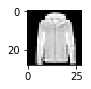

batch2:
0 T恤


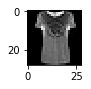

batch3:
7 运动鞋


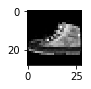

batch4:
9 踝靴


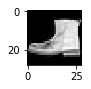

batch5:
9 踝靴


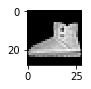

batch6:
9 踝靴


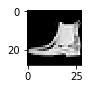

batch7:
4 外套


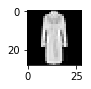

batch8:
4 外套


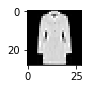

batch9:
3 裙子


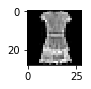

batch10:
4 外套


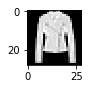

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt


def data_visualization(tfrecord_filename, num):
    filename_queue = tf.train.string_input_producer([tfrecord_filename])
    reader = tf.TFRecordReader()
    key, value = reader.read(filename_queue)
    features = tf.parse_single_example(
        value,
        features={
            'images': tf.FixedLenFeature([28, 28], tf.float32),
            'labels': tf.FixedLenFeature([], tf.int64)
        })
    images = features['images']
    labels = features['labels']

    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    dice_label = {0: "T恤", 1: "裤子", 2: "套衫", 3: "裙子", 4: "外套", 5: "凉鞋", 6: "汗衫", 7: "运动鞋", 8: "包", 9: "踝靴"}
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for i in range(num):
            imgs, labs = sess.run([images, labels])
            print('batch' + str(i+1) + ':')
            print(labs, dice_label[labs])
            plt.figure(figsize=(1, 1))
            plt.imshow(imgs, cmap='gray')
            plt.show()

        coord.request_stop()
        coord.join(threads)


data_visualization('train.tfrecord', 10)


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @File  : KNN.py
# @Author: Joker
# @Date  : 2017/11/15

import tensorflow as tf
import numpy as np
from read_tfrecord import read_tfrecord


def loadmnist():
    from tensorflow.examples.tutorials.mnist import input_data
    return input_data.read_data_sets('data/fashion', one_hot=True)


def knn(data):
    train_x, train_y = data.train.next_batch(5000)
    test_x, test_y = data.test.next_batch(200)
    #二值化处理，消除颜色深度的影响，然而并没有提高多少精确度
    # for i in range(len(train_x)):
    #     for j in range(len(train_x[0])):
    #         if train_x[i][j] >0:
    #             train_x[i][j]=1.0
    # for i in range(len(test_x)):
    #     for j in range(len(test_x[0])):
    #         if test_x[i][j] > 0:
    #             test_x[i][j] = 1.0

    xtr = tf.placeholder(tf.float32, [None, 784])
    xte = tf.placeholder(tf.float32, [784])
    distance = tf.pow(tf.reduce_sum(tf.pow(tf.add(xtr, tf.negative(xte)), 2), reduction_indices=1), 1/2)

    pred = tf.argmin(distance, 0)

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)

    right = 0
    for i in range(200):
        ansindex = sess.run(pred, {xtr: train_x, xte: test_x[i, :]})
        print('prediction is ', np.argmax(train_y[ansindex]), 'true value is ', np.argmax(test_y[i]))
        if np.argmax(test_y[i]) == np.argmax(train_y[ansindex]):
            right += 1.0
    accracy = right / 200.0
    print(accracy)


if __name__ == "__main__":
    mnist = loadmnist()
    knn(mnist)


Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
prediction is  5 true value is  5
prediction is  2 true value is  2
prediction is  2 true value is  6
prediction is  0 true value is  6
prediction is  9 true value is  9
prediction is  0 true value is  0
prediction is  1 true value is  1
prediction is  8 true value is  8
prediction is  5 true value is  5
prediction is  3 true value is  3
prediction is  6 true value is  2
prediction is  9 true value is  9
prediction is  3 true value is  3
prediction is  5 true value is  5
prediction is  2 true value is  2
prediction is  0 true value is  6
prediction is  6 true value is  6
prediction is  9 true value is  7
prediction is  5 true value is  5
prediction is  1 true value is  1
prediction is  8 true value is  8
prediction is  7 true value is  7
prediction is  4 true value is  3
prediction is  8

Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz


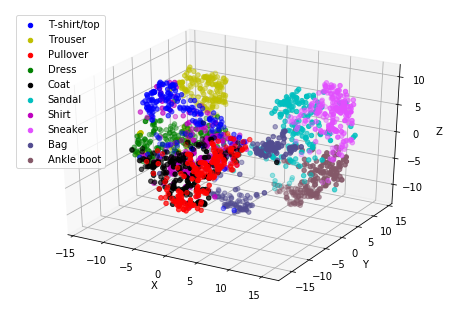

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @File  : 3D.py
# @Author: Joker
# @Date  : 2017/11/15


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def loadmnist():
    from tensorflow.examples.tutorials.mnist import input_data
    return input_data.read_data_sets('data/fashion')
data = loadmnist()
# learning_rate = 100.0, early_exaggeration = 100.0, n_iter = 1000
mnist = data.train.next_batch(2000)
X_embedded = TSNE(n_components=3).fit_transform(mnist[0])
type0_x = []
type0_y = []
type0_z = []
type1_x = []
type1_y = []
type1_z = []
type2_x = []
type2_y = []
type2_z = []
type3_x = []
type3_y = []
type3_z = []
type4_x = []
type4_y = []
type4_z = []
type5_x = []
type5_y = []
type5_z = []
type6_x = []
type6_y = []
type6_z = []
type7_x = []
type7_y = []
type7_z = []
type8_x = []
type8_y = []
type8_z = []
type9_x = []
type9_y = []
type9_z = []

for i in range(len(X_embedded)):
    if mnist[1][i] == 0:
        type0_x.append(X_embedded[i][0])
        type0_y.append(X_embedded[i][1])
        type0_z.append(X_embedded[i][2])
    if mnist[1][i] == 1:
        type1_x.append(X_embedded[i][0])
        type1_y.append(X_embedded[i][1])
        type1_z.append(X_embedded[i][2])
    if mnist[1][i] == 2:
        type2_x.append(X_embedded[i][0])
        type2_y.append(X_embedded[i][1])
        type2_z.append(X_embedded[i][2])
    if mnist[1][i] == 3:
        type3_x.append(X_embedded[i][0])
        type3_y.append(X_embedded[i][1])
        type3_z.append(X_embedded[i][2])
    if mnist[1][i] == 4:
        type4_x.append(X_embedded[i][0])
        type4_y.append(X_embedded[i][1])
        type4_z.append(X_embedded[i][2])
    if mnist[1][i] == 5:
        type5_x.append(X_embedded[i][0])
        type5_y.append(X_embedded[i][1])
        type5_z.append(X_embedded[i][2])
    if mnist[1][i] == 6:
        type6_x.append(X_embedded[i][0])
        type6_y.append(X_embedded[i][1])
        type6_z.append(X_embedded[i][2])
    if mnist[1][i] == 7:
        type7_x.append(X_embedded[i][0])
        type7_y.append(X_embedded[i][1])
        type7_z.append(X_embedded[i][2])
    if mnist[1][i] == 8:
        type8_x.append(X_embedded[i][0])
        type8_y.append(X_embedded[i][1])
        type8_z.append(X_embedded[i][2])
    if mnist[1][i] == 9:
        type9_x.append(X_embedded[i][0])
        type9_y.append(X_embedded[i][1])
        type9_z.append(X_embedded[i][2])

fig = plt.figure()
ax = Axes3D(fig)

#将数据点分成三部分画，在颜色上有区分度
type0 = ax.scatter(type0_x,type0_y,type0_z,c='b') #绘制数据点
type1 = ax.scatter(type1_x,type1_y,type1_z,c='y')
type2 = ax.scatter(type2_x,type2_y,type2_z,c='r')
type3 = ax.scatter(type3_x,type3_y,type3_z,c='g')
type4 = ax.scatter(type4_x,type4_y,type4_z,c='k')
type5 = ax.scatter(type5_x,type5_y,type5_z,c='c')
type6 = ax.scatter(type6_x,type6_y,type6_z,c='m')
type7 = ax.scatter(type7_x,type7_y,type7_z,c='#e24fff')
type8 = ax.scatter(type8_x,type8_y,type8_z,c='#524C90')
type9 = ax.scatter(type9_x,type9_y,type9_z,c='#845868')


ax.set_zlabel('Z') #坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')

ax.legend((type0, type1, type2, type3, type4, type5, type6, type7, type8, type9),
          (u'T-shirt/top', u'Trouser', u'Pullover',
           u'Dress', u'Coat', u'Sandal', u'Shirt',
           u'Sneaker', u'Bag', u'Ankle boot'), loc=0)


plt.show()


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @File  : Cnn.py
# @Author: Joker
# @Date  : 2017/11/20

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/fashion", one_hot=True)  # 读取图片数据集


# 一，函数声明部分

def weight_variable(shape):
    # 正态分布，标准差为0.1，默认最大为1，最小为-1，均值为0
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    # 创建一个结构为shape矩阵也可以说是数组shape声明其行列，初始化所有值为0.1
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, w):
    # 卷积遍历各方向步数为1，SAME：边缘外自动补0，遍历相乘
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    # 池化卷积结果（conv2d）池化层采用kernel大小为2*2，步数也为2，周围补0，取最大值。数据量缩小了4倍
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def prelu(_x, scope=None):
    """parametric ReLU activation"""
    with tf.variable_scope(name_or_scope=scope, default_name="prelu"):
        _alpha = tf.get_variable("prelu", shape=_x.get_shape()[-1],
                                 dtype=_x.dtype, initializer=tf.constant_initializer(0.9))
        return tf.maximum(0.0, _x) + _alpha * tf.minimum(0.0, _x)

# 二，定义输入输出结构

# 声明一个占位符，None表示输入图片的数量不定，28*28图片分辨率
xs = tf.placeholder(tf.float32, [None, 28 * 28])
# 类别是0-9总共10个类别，对应输出分类结果
ys = tf.placeholder(tf.float32, [None, 10])
with tf.name_scope("reshape"):
    # x_image又把xs reshape成了28*28*1的形状，因为是灰色图片，所以通道是1.作为训练时的input，-1代表图片数量不定
    x_image = tf.reshape(xs, [-1, 28, 28, 1])

# 三，搭建网络,定义算法公式，也就是forward时的计算
with tf.name_scope("conv1"):
    # 第一层卷积操作
    # 第一二参数值得卷积核尺寸大小，即patch，第三个参数是图像通道数，第四个参数是卷积核的数目，代表会出现多少个卷积特征图像;
    W_conv1 = weight_variable([5, 5, 1, 32])
    # 对于每一个卷积核都有一个对应的偏置量。
    b_conv1 = bias_variable([32])
    # 图片乘以卷积核，并加上偏执量，卷积结果28x28x32
    h_conv1 = prelu(conv2d(x_image, W_conv1) + b_conv1)
with tf.name_scope("pool1"):
    # 池化结果14x14x32 卷积结果乘以池化卷积核
    h_pool1 = max_pool_2x2(h_conv1)
with tf.name_scope("conv2"):
    # 第二层卷积操作
    # 32通道卷积，卷积出64个特征
    w_conv2 = weight_variable([5, 5, 32, 64])
    # 64个偏执数据
    b_conv2 = bias_variable([64])
    # 注意h_pool1是上一层的池化结果，#卷积结果14x14x64
    h_conv2 = prelu(conv2d(h_pool1, w_conv2) + b_conv2)
with tf.name_scope("pool2"):
    # 池化结果7x7x64
    h_pool2 = max_pool_2x2(h_conv2)
    # 原图像尺寸28*28，第一轮图像缩小为14*14，共有32张，第二轮后图像缩小为7*7，共有64张
with tf.name_scope("fc1"):
    # 第三层全连接操作
    # 二维张量，第一个参数7*7*64的patch，也可以认为是只有一行7*7*64个数据的卷积，第二个参数代表卷积个数共1024个
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    # 1024个偏执数据
    b_fc1 = bias_variable([1024])
    # 将第二层卷积池化结果reshape成只有一行7*7*64个数据# [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    # 卷积操作，结果是1*1*1024，单行乘以单列等于1*1矩阵，matmul实现最基本的矩阵相乘，不同于tf.nn.conv2d的遍历相乘，自动认为是前行向量后列向量
    h_fc1 = prelu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    # dropout操作，减少过拟合，其实就是降低上一层某些输入的权重scale，甚至置为0，升高某些输入的权值，甚至置为2，防止评测曲线出现震荡，个人觉得样本较少时很必要
    # 使用占位符，由dropout自动确定scale，也可以自定义，比如0.5，根据tensorflow文档可知，程序中真实使用的值为1/0.5=2，也就是某些输入乘以2，同时某些输入乘以0
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)  # 对卷积结果执行dropout操作
with tf.name_scope("fc2"):
    # 第四层输出操作
    # 二维张量，1*1024矩阵卷积，共10个卷积，对应我们开始的ys长度为10
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    # 最后的分类，结果为1*1*10 softmax和sigmoid都是基于logistic分类算法，一个是多分类一个是二分类
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
with tf.name_scope("loss"):
    # 四，定义loss(最小误差概率)，选定优化优化loss，
    cross_entropy = -tf.reduce_sum(ys * tf.log(y_conv))  # 定义交叉熵为loss函数
with tf.name_scope("gradientdescent_optimizer"):
    train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(cross_entropy)  # 调用优化器优化，其实就是通过喂数据争取cross_entropy最小化

# 五，开始数据训练以及评测
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(ys, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_writer = tf.summary.FileWriter('graphs/')
train_writer.add_graph(tf.get_default_graph())
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={xs: batch[0], ys: batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g" % (i, train_accuracy))
        train_step.run(feed_dict={xs: batch[0], ys: batch[1], keep_prob: 0.5})
    saver.save(sess, 'saved_model/final/model.ckpt')

    print("test accuracy %g" % accuracy.eval(feed_dict={xs: mnist.test.images, ys: mnist.test.labels, keep_prob: 1.0}))

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @File  : vaild_cnn.py
# @Author: Joker
# @Date  : 2017/11/23

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import os

mnist = input_data.read_data_sets("data/fashion", one_hot=True)  # 读取图片数据集

# 一，函数声明部分

def weight_variable(shape):
    # 正态分布，标准差为0.1，默认最大为1，最小为-1，均值为0
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    # 创建一个结构为shape矩阵也可以说是数组shape声明其行列，初始化所有值为0.1
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, w):
    # 卷积遍历各方向步数为1，SAME：边缘外自动补0，遍历相乘
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    # 池化卷积结果（conv2d）池化层采用kernel大小为2*2，步数也为2，周围补0，取最大值。数据量缩小了4倍
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def prelu(_x, scope=None):
    """parametric ReLU activation"""
    with tf.variable_scope(name_or_scope=scope, default_name="prelu"):
        _alpha = tf.get_variable("prelu", shape=_x.get_shape()[-1],
                                 dtype=_x.dtype, initializer=tf.constant_initializer(0.8))
        return tf.maximum(0.0, _x) + _alpha * tf.minimum(0.0, _x)

# 二，定义输入输出结构

# 声明一个占位符，None表示输入图片的数量不定，28*28图片分辨率
xs = tf.placeholder(tf.float32, [None, 28 * 28])
# 类别是0-9总共10个类别，对应输出分类结果
ys = tf.placeholder(tf.float32, [None, 10])
with tf.name_scope("reshape"):
    # x_image又把xs reshape成了28*28*1的形状，因为是灰色图片，所以通道是1.作为训练时的input，-1代表图片数量不定
    x_image = tf.reshape(xs, [-1, 28, 28, 1])

# 三，搭建网络,定义算法公式，也就是forward时的计算
with tf.name_scope("conv1"):
    # 第一层卷积操作
    # 第一二参数值得卷积核尺寸大小，即patch，第三个参数是图像通道数，第四个参数是卷积核的数目，代表会出现多少个卷积特征图像;
    W_conv1 = weight_variable([5, 5, 1, 32])
    # 对于每一个卷积核都有一个对应的偏置量。
    b_conv1 = bias_variable([32])
    # 图片乘以卷积核，并加上偏执量，卷积结果28x28x32
    h_conv1 = prelu(conv2d(x_image, W_conv1) + b_conv1)
with tf.name_scope("pool1"):
    # 池化结果14x14x32 卷积结果乘以池化卷积核
    h_pool1 = max_pool_2x2(h_conv1)
with tf.name_scope("conv2"):
    # 第二层卷积操作
    # 32通道卷积，卷积出64个特征
    w_conv2 = weight_variable([5, 5, 32, 64])
    # 64个偏执数据
    b_conv2 = bias_variable([64])
    # 注意h_pool1是上一层的池化结果，#卷积结果14x14x64
    h_conv2 = prelu(conv2d(h_pool1, w_conv2) + b_conv2)
with tf.name_scope("pool2"):
    # 池化结果7x7x64
    h_pool2 = max_pool_2x2(h_conv2)
    # 原图像尺寸28*28，第一轮图像缩小为14*14，共有32张，第二轮后图像缩小为7*7，共有64张
with tf.name_scope("fc1"):
    # 第三层全连接操作
    # 二维张量，第一个参数7*7*64的patch，也可以认为是只有一行7*7*64个数据的卷积，第二个参数代表卷积个数共1024个
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    # 1024个偏执数据
    b_fc1 = bias_variable([1024])
    # 将第二层卷积池化结果reshape成只有一行7*7*64个数据# [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    # 卷积操作，结果是1*1*1024，单行乘以单列等于1*1矩阵，matmul实现最基本的矩阵相乘，不同于tf.nn.conv2d的遍历相乘，自动认为是前行向量后列向量
    h_fc1 = prelu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    # dropout操作，减少过拟合，其实就是降低上一层某些输入的权重scale，甚至置为0，升高某些输入的权值，甚至置为2，防止评测曲线出现震荡，个人觉得样本较少时很必要
    # 使用占位符，由dropout自动确定scale，也可以自定义，比如0.5，根据tensorflow文档可知，程序中真实使用的值为1/0.5=2，也就是某些输入乘以2，同时某些输入乘以0
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)  # 对卷积结果执行dropout操作
with tf.name_scope("fc2"):
    # 第四层输出操作
    # 二维张量，1*1024矩阵卷积，共10个卷积，对应我们开始的ys长度为10
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    # 最后的分类，结果为1*1*10 softmax和sigmoid都是基于logistic分类算法，一个是多分类一个是二分类
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
with tf.name_scope("loss"):
    # 四，定义loss(最小误差概率)，选定优化优化loss，
    cross_entropy = -tf.reduce_sum(ys * tf.log(y_conv))  # 定义交叉熵为loss函数
with tf.name_scope("gradientdescent_optimizer"):
    train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(cross_entropy)  # 调用优化器优化，其实就是通过喂数据争取cross_entropy最小化

# 五，开始数据训练以及评测
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(ys, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


saver = tf.train.Saver()
with tf.Session() as sess:
        check_point_path = 'saved_model/50000' # 保存好模型的文件路径
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir=check_point_path)
        saver.restore(sess,ckpt.model_checkpoint_path)

        Y = np.zeros(10000)
        Ytemp = y_conv.eval(feed_dict={xs: mnist.test.images, ys: mnist.test.labels, keep_prob: 1.0})
        for i in range(10000):
            #生成0-9标签
            Y[i] = np.argmax(Ytemp[i])


        print("test accuracy %g" % accuracy.eval(feed_dict={xs: mnist.test.images, ys: mnist.test.labels, keep_prob: 1.0}))
#生成txt文件
fp = open("test.txt", "w+")
for i in range(10000):
    fp.write(str(int(Y[i]))+"\n")
fp.close()